In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('bez_nedostajucih.csv')

In [4]:
data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
3,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
4,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN


### Kodiranje kategorickih atributa i izbacivanje nepotrebnih kolona

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [6]:
def mapi(str):
    if 'Summer' in str:
        return 0
    if 'Winter' in str:
        return 1
    else:
        return None

Izbacujemo kolone koje nam nisu potrebne.

In [7]:
nesto = data.drop(columns = ['ID', 'Name', 'Team', 'City', 'Event', 'Season', 'Year'])

In [8]:
kolone = nesto.columns.to_list()

In [9]:
spss_data = nesto[kolone]
spss_data['Medal'].fillna('No_Medal', inplace= True)

In [10]:
spss_data

,Sex,Age,Height,Weight,NOC,Games,Sport,Medal
0,M,24.0,180.0,80.0,CHN,1992 Summer,Basketball,No_Medal
1,M,23.0,170.0,60.0,CHN,2012 Summer,Judo,No_Medal
2,F,21.0,185.0,82.0,NED,1988 Winter,Speed Skating,No_Medal
3,F,21.0,185.0,82.0,NED,1988 Winter,Speed Skating,No_Medal
4,F,25.0,185.0,82.0,NED,1992 Winter,Speed Skating,No_Medal
...,...,...,...,...,...,...,...,...
52261,M,20.0,160.0,56.0,IRL,1964 Summer,Boxing,No_Medal
52262,M,20.0,192.0,93.0,AUS,2016 Summer,Canoeing,No_Medal
52263,M,26.0,170.0,65.0,AUS,1976 Summer,Athletics,No_Medal
52264,M,30.0,170.0,65.0,AUS,1980 Summer,Athletics,No_Medal


## Eksportovanje podataka za SPSS

In [14]:
putanja = 'SPSS.csv'
spss_data.to_csv(putanja, index=False)

## Kodiranje kategoričkih atributa

Za pol i igre sam ručno mapiralo, dok sam za ostale atribute koristio label_encoder.

In [8]:
mapiranje = {'M' : 0, 'F' : 1}

nesto['Sex'] = nesto['Sex'].map(mapiranje)
nesto['Sport'] = label_encoder.fit_transform(nesto['Sport'])
nesto['NOC'] = label_encoder.fit_transform(nesto['NOC'])
nesto['Games'] = nesto['Games'].map(mapi)

In [9]:
y = data['Medal']
x = nesto.columns.to_list()[:-1]

X = nesto[x]
# popunjavam None vrednosti sa No_Medal
Y = y.fillna('No_Medal')

In [10]:
X.head()

,Sex,Age,Height,Weight,NOC,Games,Sport
0,0,24.0,180.0,80.0,40,0,6
1,0,23.0,170.0,60.0,40,0,26
2,1,21.0,185.0,82.0,140,1,42
3,1,21.0,185.0,82.0,140,1,42
4,1,25.0,185.0,82.0,140,1,42


## Balansiranje podataka

 Zato sto imamo mnogo vise ljudi bez medalje (45000) nego ljudi sa medaljom (3*2000). Koristio sam SMOTEENN metodu koja je kombinacija over-samplinga i under-samplinga kako bih dobio optimalne podatke

[]

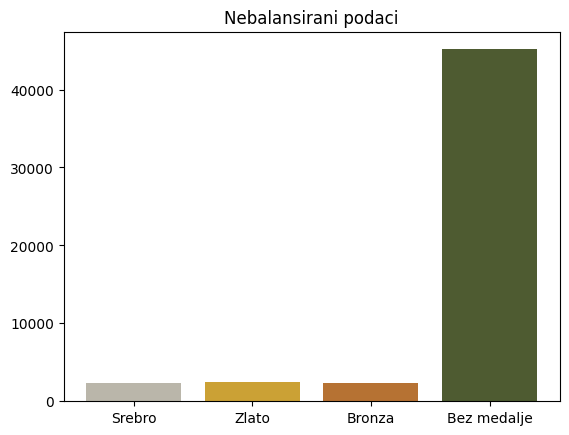

In [10]:
medalje = data.Medal.value_counts()

boje = ['#BAB6AA', '#CBA135', '#B67233', '#4E5B31']
plt.bar(['Srebro', 'Zlato', 'Bronza', 'Bez medalje'], [medalje[1], medalje[0], medalje[2], data.Medal.isna().sum()], color = boje)
plt.title('Nebalansirani podaci')
plt.plot()

In [11]:
from imblearn.combine import SMOTEENN
from collections import Counter
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [12]:
def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : \n{}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : \n{}. ".format(type(sampler).__name__,\
                                                                        Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled

In [13]:
smoteenn = SMOTEENN(random_state=22, sampling_strategy='auto')
X_resampled, y_resampled = resample(smoteenn, X, Y)

Number of instances before resampling with SMOTEENN : 
dict_items([('No_Medal', 45165), ('Bronze', 2346), ('Gold', 2429), ('Silver', 2326)]). 
Number of instances after  resampling with SMOTEENN : 
dict_items([('Bronze', 36299), ('Gold', 36438), ('No_Medal', 26405), ('Silver', 35992)]). 


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=22, stratify=y_resampled)

[]

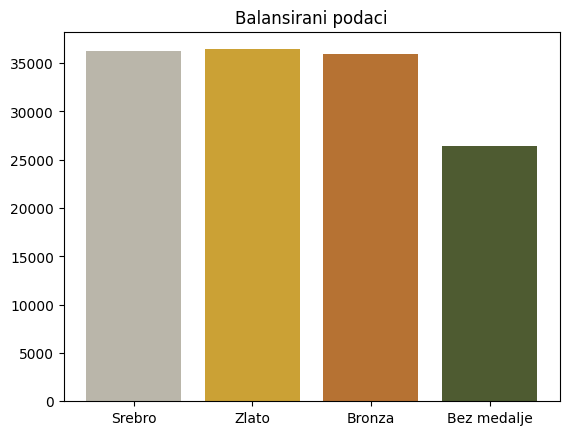

In [15]:
medalje = y_resampled.value_counts()
boje = ['#BAB6AA', '#CBA135', '#B67233', '#4E5B31']
plt.bar(['Srebro', 'Zlato', 'Bronza', 'Bez medalje'], [medalje[1], medalje[0], medalje[2], medalje[3]], color = boje)
plt.title('Balansirani podaci')
plt.plot()

## Standardizacija podataka

In [16]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)
X_test = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

## Eksportovanje podataka za klasifikaciju

In [17]:
joblib.dump((X_train, X_test, y_train, y_test), 'classification_data.joblib')

['classification_data.joblib']

## Standardizacija podataka za klasterovanje

In [18]:
# nesto['Medal'] = label_encoder.fit_transform(nesto['Medal'])
x = nesto.columns.to_list()
X = nesto[x]
X.drop(columns='Medal', inplace=True)

In [19]:
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled

,Sex,Age,Height,Weight,NOC,Games,Sport
0,0.0,0.226415,0.552083,0.291005,0.180995,0.0,0.111111
1,0.0,0.207547,0.447917,0.185185,0.180995,0.0,0.481481
2,1.0,0.169811,0.604167,0.301587,0.633484,1.0,0.777778
3,1.0,0.169811,0.604167,0.301587,0.633484,1.0,0.777778
4,1.0,0.245283,0.604167,0.301587,0.633484,1.0,0.777778
...,...,...,...,...,...,...,...
52261,0.0,0.150943,0.343750,0.164021,0.420814,0.0,0.185185
52262,0.0,0.150943,0.677083,0.359788,0.054299,0.0,0.203704
52263,0.0,0.264151,0.447917,0.211640,0.054299,0.0,0.055556
52264,0.0,0.339623,0.447917,0.211640,0.054299,0.0,0.055556


## Eksportovanje podataka za klasterovanje

In [20]:
joblib.dump((X_scaled, Y), 'clustering_data.joblib')

['clustering_data.joblib']

In [6]:
max(data.Year)

2016